# <u>Analysis and Results </u>

### Task-1: 
- Total Successful Reconstructed Samples = 40 out of 120

### Task-2:
- Total Successful Reconstructed Samples = 32 out of 100
- Possible reasons and some analysis for failure given in this notebook below: [Here](#Reasons)
 

### Task-3:
- Logistic Regression:
    - Total Successful Reconstructed Samples = 55 out of 100

- Naive Bayes Classifier:
    - Total Successful Reconstructed Samples = 100 out of 100

### Task-4:
- Plots of epsilon vs accuracy given: [Here](#Task4)


# Code:

In [1]:
# !pip install adversarial-robustness-toolbox

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Task-1

In [2]:
from art.estimators.classification.scikitlearn import ScikitlearnLogisticRegression
from art.attacks.inference.reconstruction import DatabaseReconstruction

In [3]:
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression(max_iter=512)
model.fit(X_train, y_train)

LogisticRegression(max_iter=512)

In [4]:
X_train.shape, y_train.shape

((120, 4), (120,))

In [5]:
non_private_art = ScikitlearnLogisticRegression(model)
dbrecon = DatabaseReconstruction(non_private_art)

In [6]:
def get_inference_rmse(X_train, x_pred, target_row):
    # print("Inference RMSE: {}".format(
    # np.sqrt(((X_train[target_row] - x) ** 2).sum() / X_train.shape[1])))
    val = np.sqrt(((X_train[target_row] - x_pred) ** 2).sum() / X_train.shape[1])
    return val

In [7]:
def launch_attack(X_train, y_train, dbrecon):
    recon_attempts = []
    rmse_scores = []
    
    for target_row in tqdm(range(len(X_train))):
        X_train_removed = np.delete(X_train, target_row, axis=0)
        y_train_removed = np.delete(y_train, target_row, axis=0)

        x, y = dbrecon.reconstruct(X_train_removed, y_train_removed)
        success = (np.argmax(y) == y_train[target_row])
        rmse = get_inference_rmse(X_train, x, target_row)

        recon_attempts.append(success)
        rmse_scores.append(rmse)
        
    return recon_attempts, rmse_scores

In [8]:
def analyze_attack(recon_attempts, rmse_scores):
    # Calculate the sum of successful recon_attempts
    successful_attempts = sum(recon_attempts)
    
    # Calculate the average of rmse_scores
    average_rmse = sum(rmse_scores) / len(rmse_scores) if rmse_scores else 0
    
    # Print the results nicely
    print(f"Total Successful Reconstructions: {successful_attempts}/{len(recon_attempts)}")
    print(f"Average RMSE Score: {average_rmse:.10f}")

In [51]:
recon_attempts, rmse_scores = launch_attack(X_train, y_train, dbrecon)

100%|███████████████████████████████████████████████████| 120/120 [19:54<00:00,  9.96s/it]


In [52]:
analyze_attack(recon_attempts, rmse_scores)

Total Successful Reconstructions: 40/120
Average RMSE Score: 1.6529702633


# Task-2

In [9]:
from sklearn.datasets import load_breast_cancer

# Load Breast Cancer Wisconsin (Diagnostic) dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [10]:
X_train.shape, y_train.shape

((455, 30), (455,))

In [11]:
non_private_art = ScikitlearnLogisticRegression(model)
dbrecon = DatabaseReconstruction(non_private_art)

In [12]:
X_train_subset, y_train_subset = X_train[:100], y_train[:100]
X_train_subset.shape, y_train_subset.shape

((100, 30), (100,))

In [13]:
recon_attempts, rmse_scores = launch_attack(X_train_subset, y_train_subset, dbrecon)

100%|███████████████████████████████████████████████████| 100/100 [40:14<00:00, 24.15s/it]


In [14]:
analyze_attack(recon_attempts, rmse_scores)

Total Successful Reconstructions: 32/100
Average RMSE Score: 119.6775193837


<a id='Reasons'></a>
## Possible Reason for Failure

- <u>Overlap between classes</u>: If the classes are not well-separated in the feature space, removing a sample and trying to reconstruct it may result in misclassification, as the decision boundary might not be clear-cut.

- <u>Highly correlated features</u>: If the features are highly correlated, removing one sample might not significantly affect the decision boundary, leading to successful reconstruction. However, if features are not highly correlated, removing a sample might have a larger impact on the decision boundary, making reconstruction more difficult.

- <u>Non-linear decision boundary</u>: Logistic regression assumes a linear decision boundary. If the true decision boundary is non-linear, removing samples and attempting reconstruction may fail, as logistic regression cannot capture complex relationships between features.

- <u>Imbalanced classes</u>: If the classes are imbalanced, removing samples from the majority class might have less impact on the decision boundary compared to removing samples from the minority class.

- <u>Noise in the data</u>: If the dataset contains noise or outliers, removing samples may not significantly affect the decision boundary, leading to successful reconstruction even if the removed sample is important for classification.

## Data anlysis for Wisconsin Dataset
#### Key Findings:
- There is a class imbalance having 209 negative samples and 350 positive samples
- Also, for some features, there is a non-linear decision boundary

In [16]:
# Convert to DataFrame for easier manipulation and visualization
df = pd.DataFrame(data=X, columns=data.feature_names)
df['target'] = y  # Adding the target variable to the DataFrame

In [17]:
# Display the first few rows of the dataframe
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [18]:
# Summary statistics for numerical features
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [19]:
# Check for null values
df.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

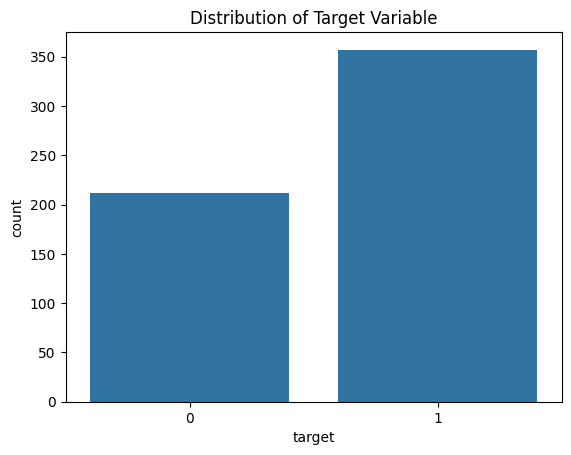

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Countplot for the target variable
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.show()

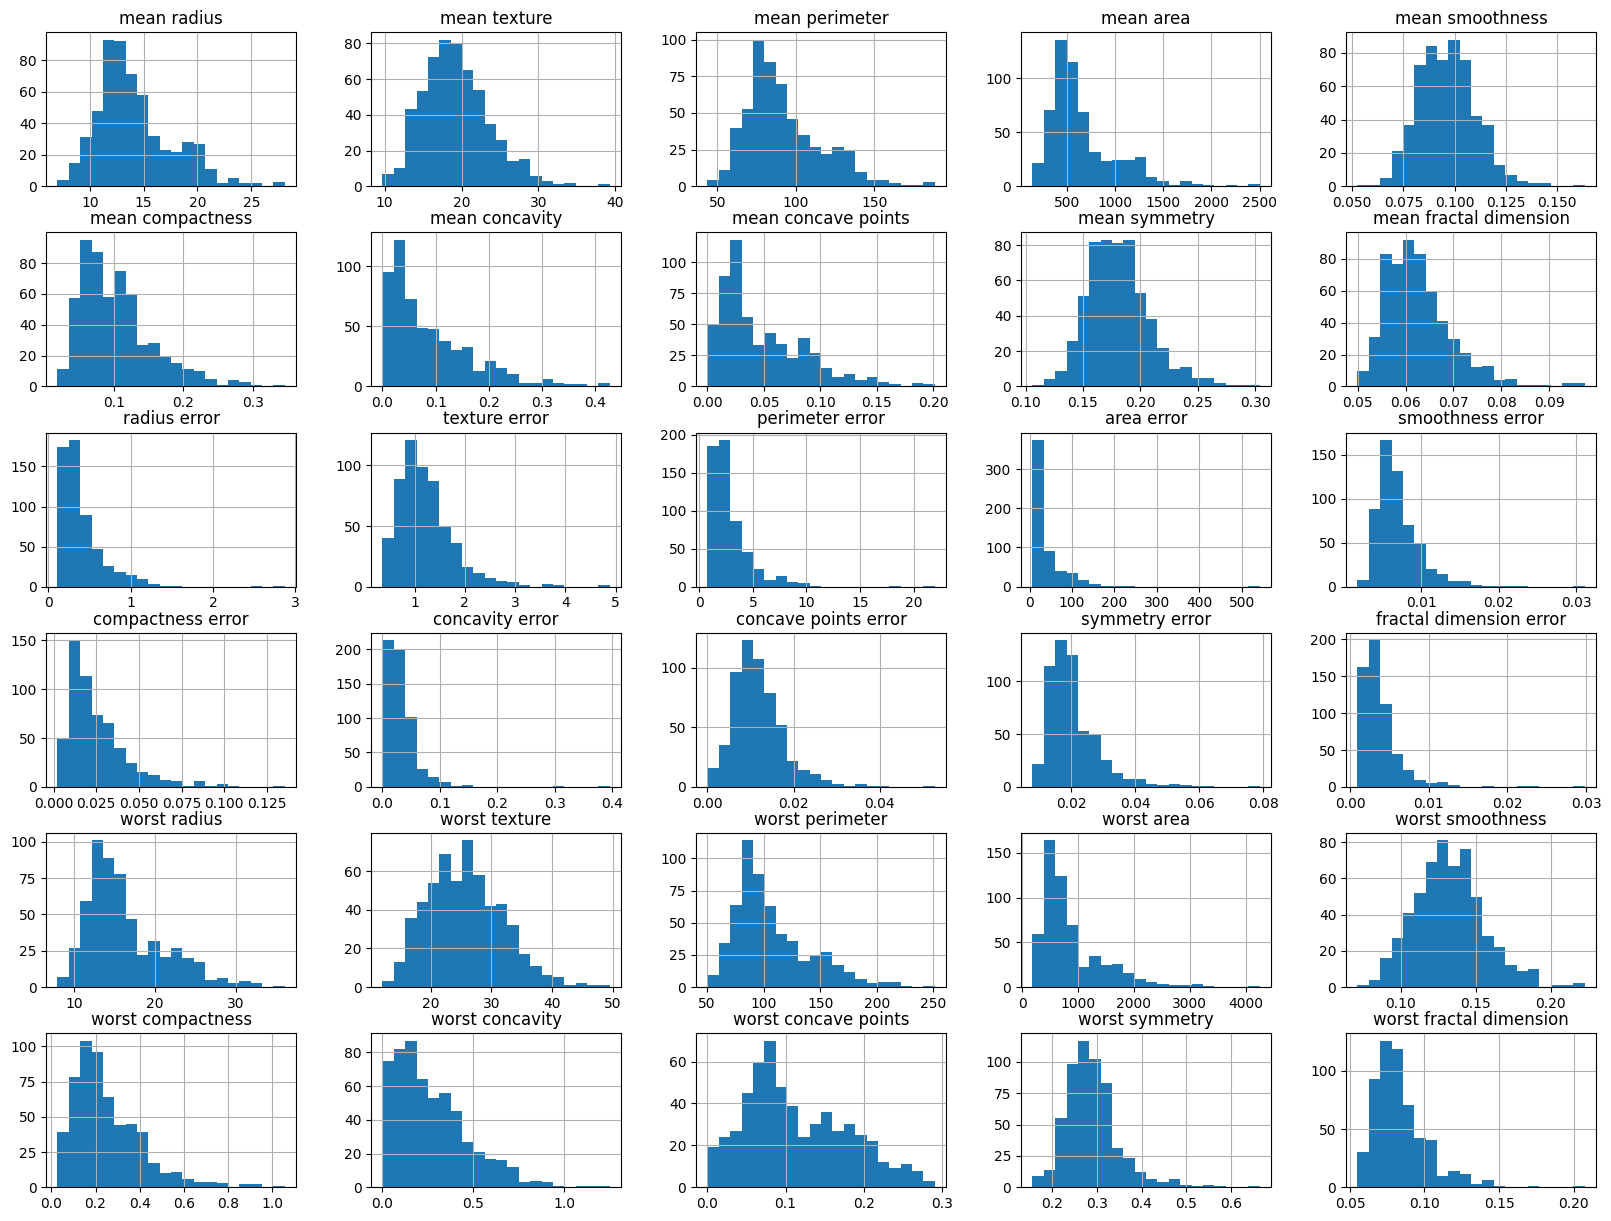

In [21]:
# Histograms for features to understand distributions
df.drop('target', axis=1).hist(bins=20, figsize=(20, 15))
plt.show()

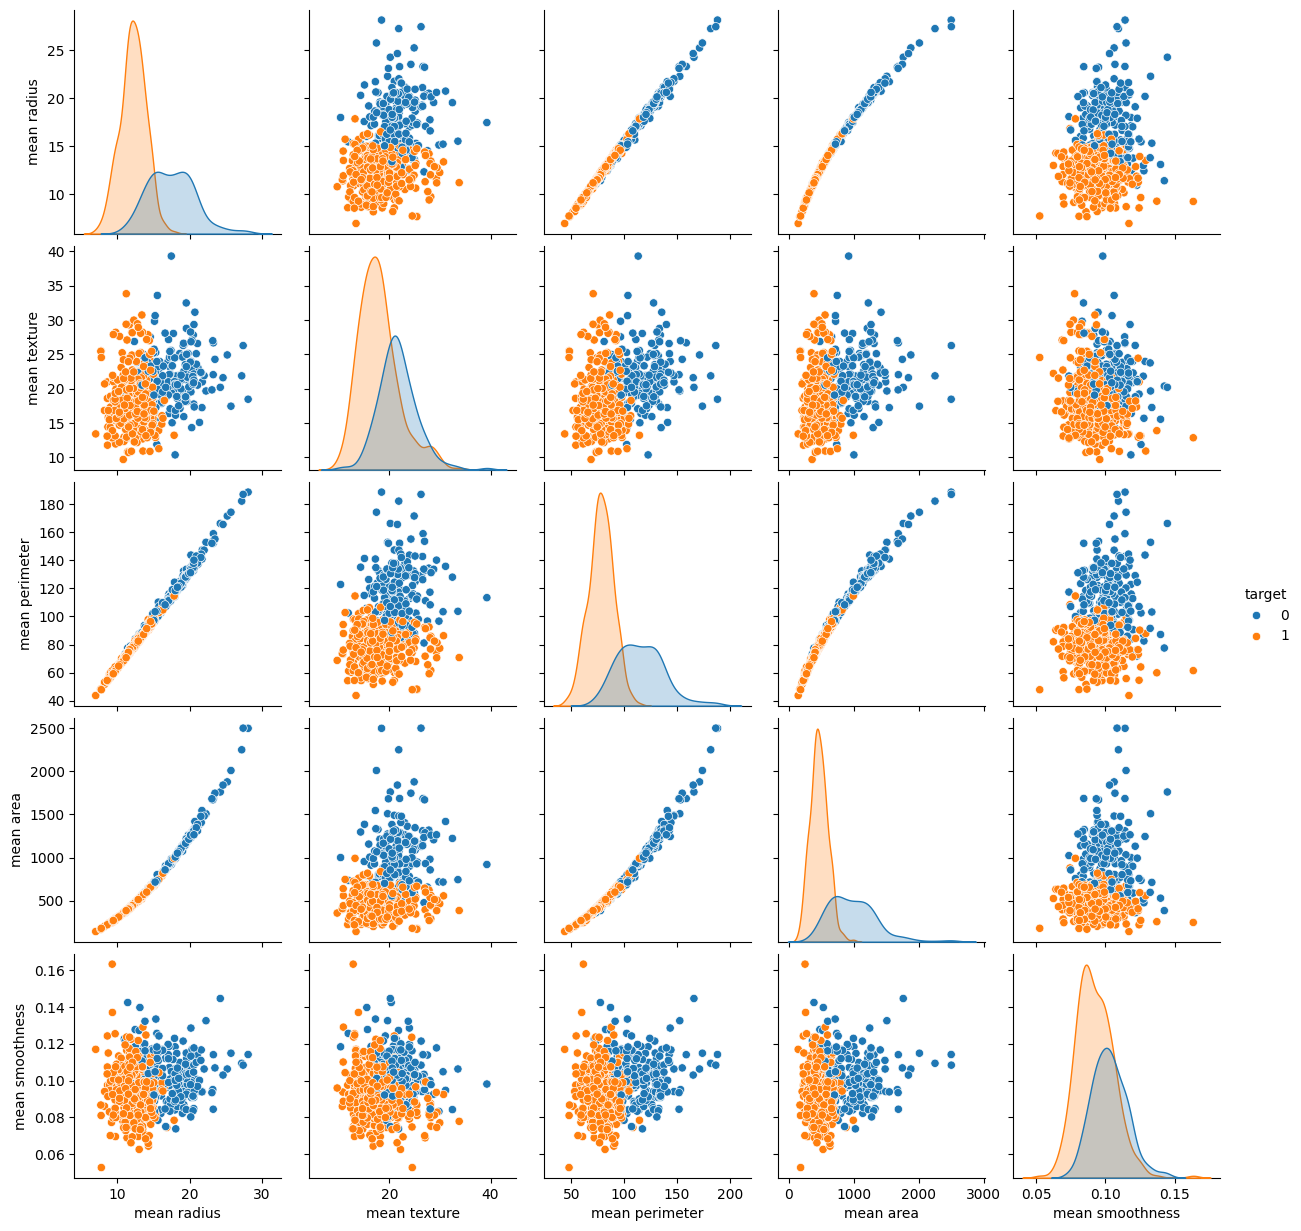

In [24]:
# Pairplot for a subset of features
sns.pairplot(df, vars=df.columns[:5], hue='target')
plt.show()

# Task-3

In [3]:
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from art.estimators.classification.scikitlearn import ScikitlearnLogisticRegression, ScikitlearnGaussianNB

In [4]:
# Generate a synthetic dataset for a four-class classification problem
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, n_classes=4, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 20), (200, 20), (800,), (200,))

In [27]:
# Initialize the classifiers
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
gaussian_nb_model = GaussianNB()

# Train the Logistic Regression model
logistic_model.fit(X_train, y_train)

# Train the Gaussian Naive Bayes model
gaussian_nb_model.fit(X_train, y_train)

# Evaluate the training accuracy of both models
logistic_accuracy = logistic_model.score(X_train, y_train)
gaussian_nb_accuracy = gaussian_nb_model.score(X_train, y_train)

print(f"Logistic Regression Training Accuracy: {logistic_accuracy*100:.2f}%")
print(f"Gaussian Naive Bayes Training Accuracy: {gaussian_nb_accuracy*100:.2f}%")

Logistic Regression Training Accuracy: 65.00%
Gaussian Naive Bayes Training Accuracy: 64.38%


In [28]:
non_private_art1 = ScikitlearnLogisticRegression(logistic_model)
dbrecon1 = DatabaseReconstruction(non_private_art1)

non_private_art2 = ScikitlearnGaussianNB(gaussian_nb_model)
dbrecon2 = DatabaseReconstruction(non_private_art2)

In [29]:
def launch_attack(X_train, y_train, dbrecon1, dbrecon2, target_rows):
    lr_recon_attempts = []
    lr_rmse_scores = []
    nb_recon_attempts = []
    nb_rmse_scores = []
    
    for target_row in tqdm(target_rows):
        X_train_removed = np.delete(X_train, target_row, axis=0)
        y_train_removed = np.delete(y_train, target_row, axis=0)

        x1, y1 = dbrecon1.reconstruct(X_train_removed, y_train_removed)
        x2, y2 = dbrecon2.reconstruct(X_train_removed, y_train_removed)
        
        lr_success = (np.argmax(y1) == y_train[target_row])
        lr_rmse = get_inference_rmse(X_train, x1, target_row)
        nb_success = (np.argmax(y2) == y_train[target_row])
        nb_rmse = get_inference_rmse(X_train, x2, target_row)

        lr_recon_attempts.append(lr_success)
        lr_rmse_scores.append(lr_rmse)
        nb_recon_attempts.append(nb_success)
        nb_rmse_scores.append(nb_rmse)
        
    return lr_recon_attempts, lr_rmse_scores, nb_recon_attempts, nb_rmse_scores

In [32]:
# Select 100 random samples from the dataset
np.random.seed(42)
target_rows = np.random.choice(range(len(X_train)), size=100, replace=False)

In [33]:
lr_recon_attempts, lr_rmse_scores, nb_recon_attempts, nb_rmse_scores = launch_attack(X_train, y_train, dbrecon1, dbrecon2, target_rows)

100%|████████████████████████████████████████████████| 100/100 [3:36:24<00:00, 129.84s/it]


In [34]:
analyze_attack(lr_recon_attempts, lr_rmse_scores)

Total Successful Reconstructions: 55/100
Average RMSE Score: 4.8822499688


In [35]:
analyze_attack(nb_recon_attempts, nb_rmse_scores)

Total Successful Reconstructions: 100/100
Average RMSE Score: 4.6913130704


<a id="Task4"></a>
# Task-4

In [8]:
# !pip install diffprivlib
warnings.filterwarnings('ignore')

In [9]:
from diffprivlib.models import GaussianNB as DPGaussianNB

# Initialize the differentially private GaussianNB model
# Note: `epsilon` controls the privacy guarantee. A smaller epsilon means more privacy but potentially less accuracy.
# `data_norm` is not a parameter for DPGaussianNB, as it works differently from DPLogisticRegression.
dp_gaussian_nb_model = DPGaussianNB(epsilon=1.0)

# Train the model with differential privacy
dp_gaussian_nb_model.fit(X_train, y_train)

# Evaluate its accuracy on the test set
dp_gaussian_nb_accuracy = dp_gaussian_nb_model.score(X_test, y_test)
print(f"Differentially Private GaussianNB Test Accuracy: {dp_gaussian_nb_accuracy*100:.2f}%")

Differentially Private GaussianNB Test Accuracy: 33.00%


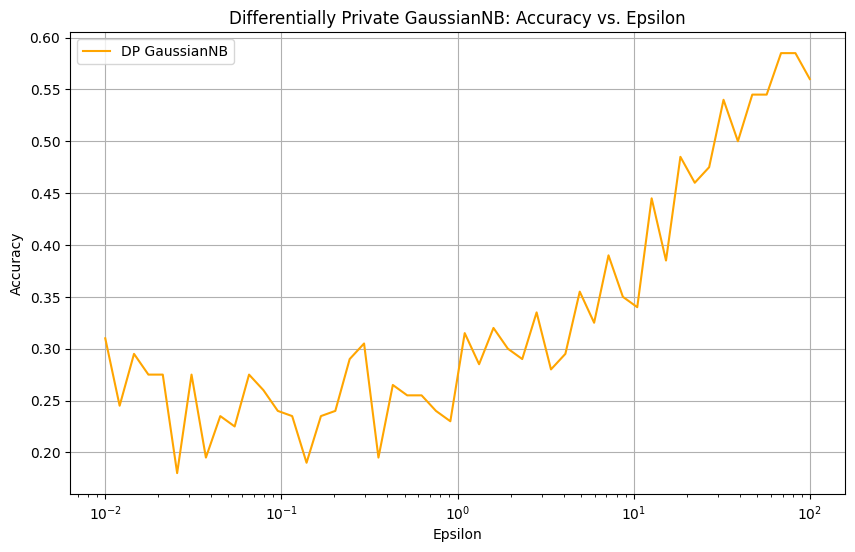

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB as DPGaussianNB

# Assuming X_train, X_test, y_train, y_test are already defined
epsilons = np.logspace(-2, 2, 50)
accuracies_gnb = []

for eps in epsilons:
    dp_gnb_model = DPGaussianNB(epsilon=eps)
    dp_gnb_model.fit(X_train, y_train)
    accuracy = dp_gnb_model.score(X_test, y_test)
    accuracies_gnb.append(accuracy)

# Plot the accuracy vs epsilon for GaussianNB
plt.figure(figsize=(10, 6))
plt.semilogx(epsilons, accuracies_gnb, label='DP GaussianNB', color='orange')
plt.title('Differentially Private GaussianNB: Accuracy vs. Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from diffprivlib.models import LogisticRegression as DPLogisticRegression
from diffprivlib.models import GaussianNB as DPGaussianNB

# Initialize the differentially private logistic regression model
dp_logistic_model = DPLogisticRegression(epsilon=1.0, data_norm=12.0)

# Train the model with differential privacy
dp_logistic_model.fit(X_train, y_train)

# Evaluate its accuracy on the test set
dp_logistic_accuracy = dp_logistic_model.score(X_test, y_test)
print(f"Differentially Private Logistic Regression Test Accuracy: {dp_logistic_accuracy*100:.2f}%")

Differentially Private Logistic Regression Test Accuracy: 19.00%


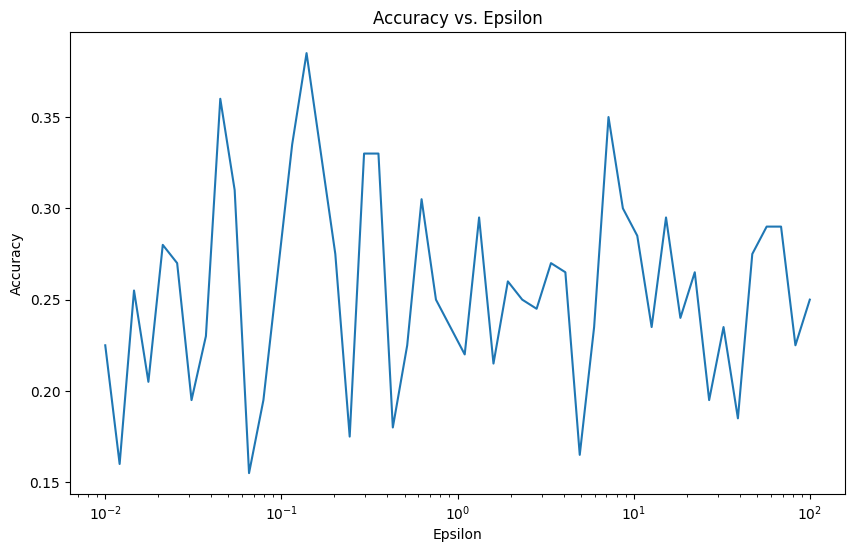

In [12]:
import matplotlib.pyplot as plt

epsilons = np.logspace(-2, 2, 50)
accuracies = []

for eps in epsilons:
    dp_model = DPLogisticRegression(epsilon=eps, data_norm=12.0)
    dp_model.fit(X_train, y_train)
    accuracy = dp_model.score(X_test, y_test)
    accuracies.append(accuracy)

# Plot the accuracy vs epsilon
plt.figure(figsize=(10, 6))
plt.semilogx(epsilons, accuracies)
plt.title('Accuracy vs. Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()